In [1]:
import sys
sys.path.append("../classes")

In [2]:
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from geno_classifier import *
from itertools import starmap, product

import GEOparse

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Clustering on diff values

In [3]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)

### breast-cancer

In [4]:
bc_results = pickle.load(open('../results/breast_cancer_2.results','rb'))
bc_labels_ = pickle.load(open('../datasets/breast_cancer_2_y','rb'))

breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=True, use_pathways=True, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

In [5]:
len(list(starmap(change_lable, product(bc_labels_, 'bc'))))

176

In [6]:
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-25.490606,-100.777030,7.129360e-06,-55.414072,0.000007
bc_unhealthy,-21.389085,96.445184,-1.006312e-06,73.618178,-0.000001
bc_unhealthy,-29.843938,38.294390,-1.006312e-06,256.413877,-0.000001
bc_healthy,-14.526884,-100.777037,5.131799e-07,-44.661390,0.000002
bc_unhealthy,-12.184960,6.018669,5.672039e-06,-55.414075,0.000006


### lung-cancer

In [7]:
lc_results = pickle.load(open('../results/lung_cancer_1.results','rb'))
lc_labels_ = pickle.load(open('../datasets/lung_cancer_1_y','rb'))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

In [8]:
lung_cancer[lung_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
lg_unhealthy,48.843000,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,2.642386,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,41.381614,-4.367172,-0.000006,-82.204632,-0.000011
lg_unhealthy,-3.062908,109.866720,-0.000005,-114.462695,-0.000009
lg_unhealthy,89.662783,138.648466,-0.000006,-103.710008,-0.000011


In [16]:
cc_results = pickle.load(open('../results/colon_cancer.results','rb'))
cc_labels_ = pickle.load(open('../datasets/colon_cancer_Xy','rb'))["y"]

colon_cancer, colon_cancer_y = preprocess_results(cc_results, cc_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

colon_cancer.index = starmap(change_lable, product(cc_labels_, ['cc']))

In [17]:
colon_cancer[colon_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
cc_healthy,-56.854475,81.990621,-0.000003,-20.717564,-0.000003
cc_healthy,24.866507,-51.435305,-0.000003,-20.717564,-0.000003
cc_unhealthy,-51.641041,-51.765993,-0.000003,145.949103,-0.000002
cc_healthy,-22.276013,-36.606562,0.000001,-20.717560,0.000001
cc_unhealthy,-11.444609,-113.935285,0.000025,-20.717542,0.000027


### diseases combined

In [18]:
classes = {'bc_unhealthy': 0, 'bc_healthy': 1, 'lg_unhealthy': 2, 'lg_healthy': 3, 'cc_healthy':4, 'cc_unhealthy':5}

In [23]:
diseases = pd.concat([breast_cancer, lung_cancer, colon_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)

### healthy grey, bc magenta, lg pink

In [25]:
colors = {0 : 'darkmagenta', 1 : 'lightpink', 2 : 'grey', 3:'lightblue', 4:'green', 5:'red'}

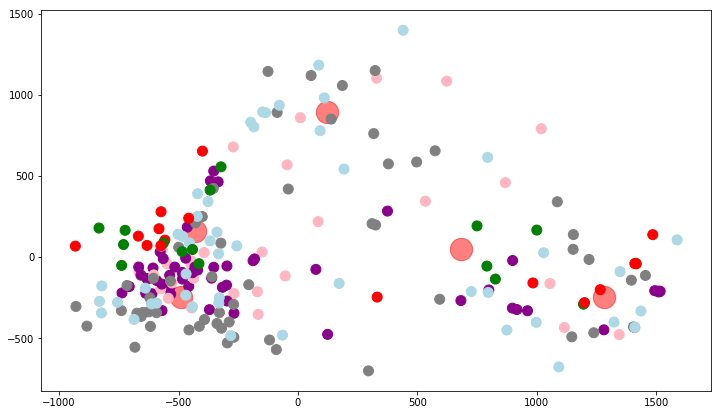

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

In [27]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [28]:
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.099351249445423, 0.11300866851679771, 0.10574078689656395)

## t-SNE

In [29]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)

In [30]:
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)

In [31]:
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.07788853979966907, 0.081421279887643, 0.07961574009080065)

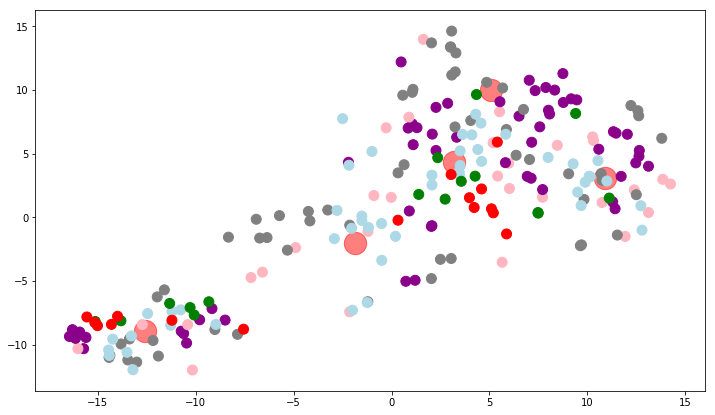

In [32]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## LDA

In [33]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(diseases, y)

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


In [34]:
kmeans_lda = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_lda)

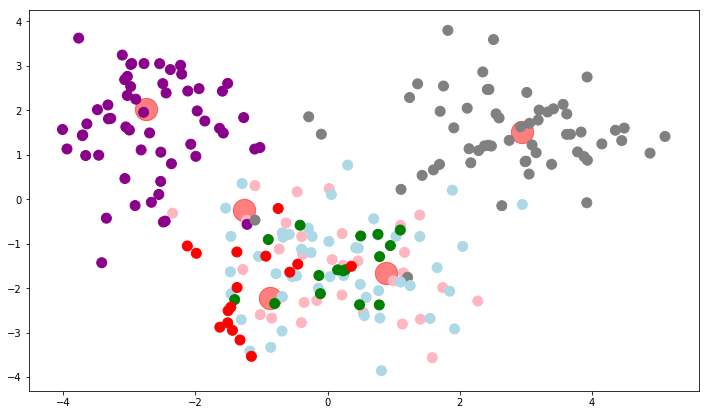

In [35]:
plt.figure(figsize=(12, 7))

centers = kmeans_lda.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], c=[colors[i] for i in y], s=100)

## K-best

In [36]:
diseases_reduced_kbest = SelectKBest(k=2).fit_transform(diseases, y)

In [37]:
kmeans_kbest = KMeans(n_clusters=5, random_state=42).fit(diseases)

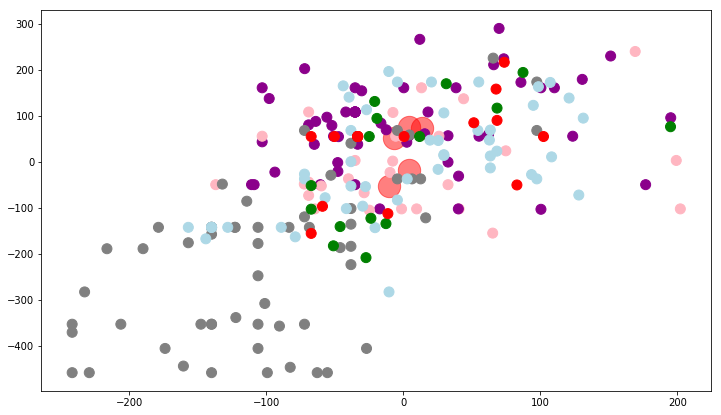

In [38]:
plt.figure(figsize=(12, 7))

centers = kmeans_kbest.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], c=[colors[i] for i in y], s=100)

## Hierarchical clustering

In [39]:
from scipy.cluster import hierarchy

In [40]:
labels_ = list(diseases.iterrows())
labels = dict()
for i in range(len(labels_)):
    labels[i] = labels_[i][0]
labels = np.array(list(labels.items()))

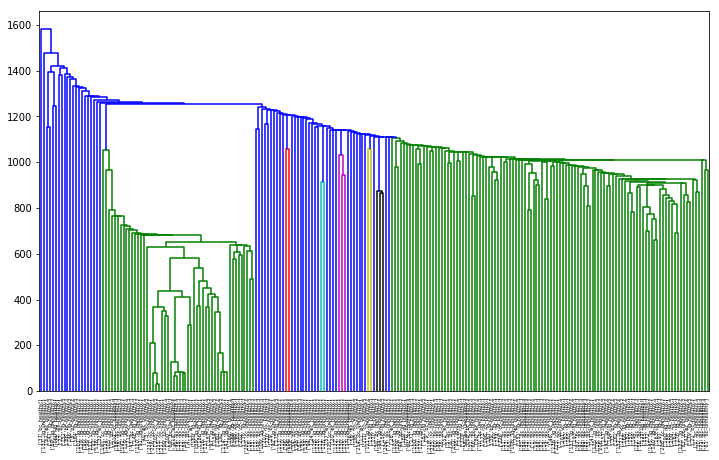

In [41]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-diff")

# Using no Pathways or Diff Values

In [43]:
breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=False, use_pathways=False, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=False, use_pathways=False, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

cc_results = pickle.load(open('../results/colon_cancer.results','rb'))
cc_labels_ = pickle.load(open('../datasets/colon_cancer_Xy','rb'))["y"]

colon_cancer, colon_cancer_y = preprocess_results(cc_results, cc_labels_, 
                                                use_diff_score=False, use_pathways=False, 
                                                scale=False, use_one_hot=False)

colon_cancer.index = starmap(change_lable, product(cc_labels_, ['cc']))

## PCA

In [44]:
diseases = pd.concat([breast_cancer, lung_cancer, colon_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.17518753799678966, 0.18488119533241643, 0.17990388186567072)

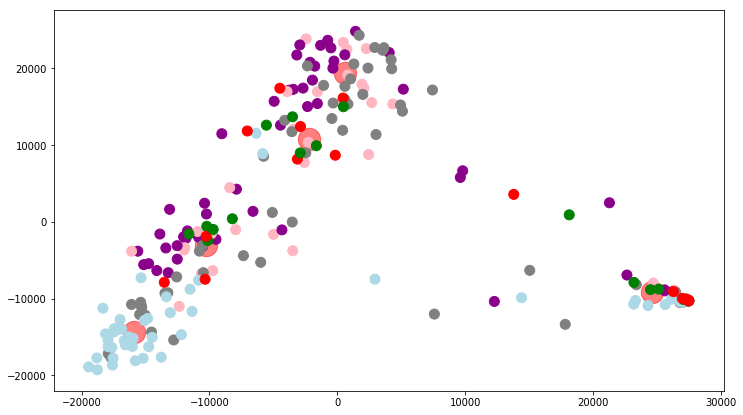

In [45]:
plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

## t-SNE

In [46]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.23071347851655236, 0.2434631412033531, 0.23691690337145568)

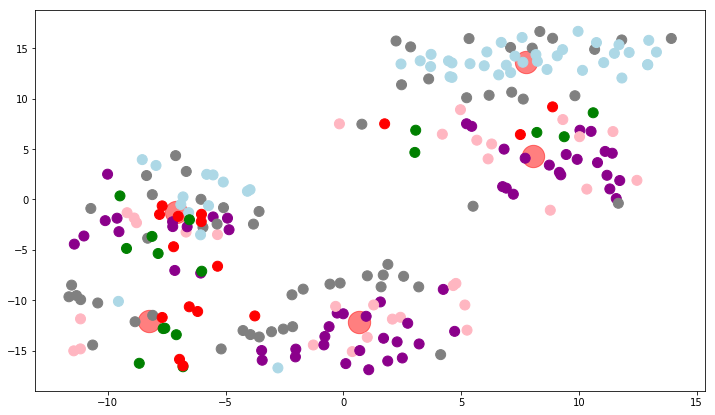

In [47]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## H-Clustering

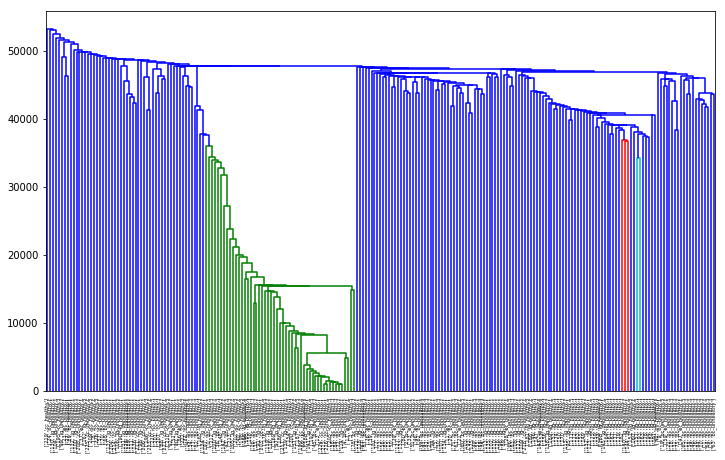

In [51]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-nodiff")